<a href="https://colab.research.google.com/github/coronarita1991/AIFFEL_RESEARCH_STUDY/blob/main/Image_Augmentation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!nvidia-smi

Wed Jul  3 07:59:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    On  |   00000000:81:00.0 Off |                  N/A |
|  0%   34C    P8             17W /  200W |       0MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 프로젝트: CutMix 또는 Mixup 비교실험 하기
지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지 마세요!

우선 주요 라이브러리 버전을 확인해 볼까요?


### 루브릭
#### 1.CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?
    - CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.  
#### 2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?  
    - Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함  
#### 3	여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?  
    - 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

In [2]:
# !pip install --upgrade tensorflow[and-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 9.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 17.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 27.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 21.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 16.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.5/197.5 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 23.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━

In [11]:
# !pip install tensorflow_datasets

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
# TensorFlow and tf.keras
from tensorflow import keras

# Helper libraries
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- Load Dataset

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [5]:
print(len(ds_train), len(ds_test))

12000 8580


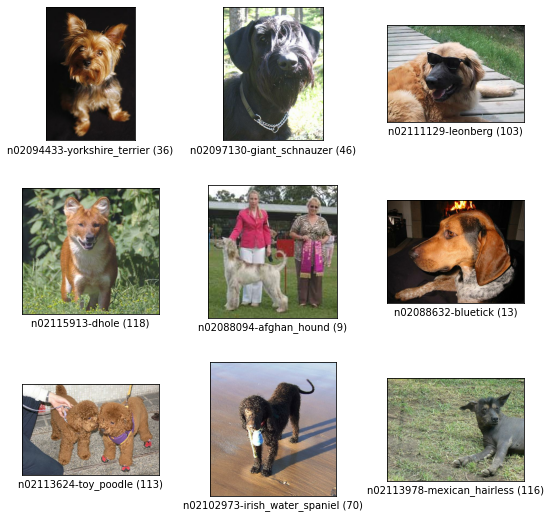

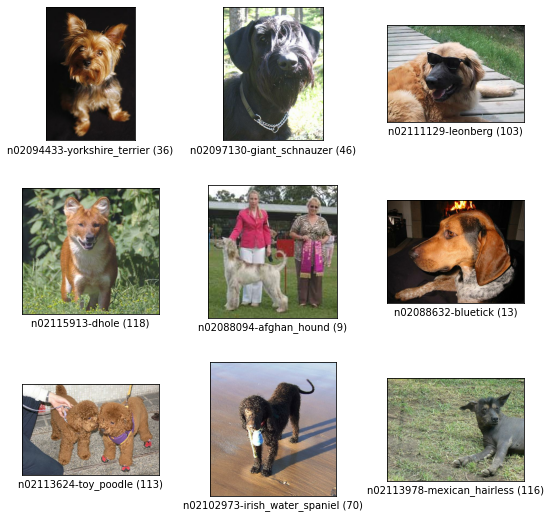

In [6]:
tfds.show_examples(ds_train, ds_info)

In [7]:
ds_info.features # 120개의 견종 분류

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [8]:
num_classes = ds_info.features['label'].num_classes
num_classes

120

In [9]:
print("Train data : {}".format(len(ds_train))) # 12000
print("Test data : {}".format(len(ds_test))) # 8580

Train data : 12000
Test data : 8580


In [10]:
# class분포 확인
ds_info.features['label']

ClassLabel(shape=(), dtype=tf.int64, num_classes=120)

In [11]:
class_names= ds_info.features['label'].names

In [12]:
ds_train

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [13]:
class_counts = {name: 0 for name in class_names}

for _, label in ds_train:
    class_counts[class_names[label.numpy()]] += 1

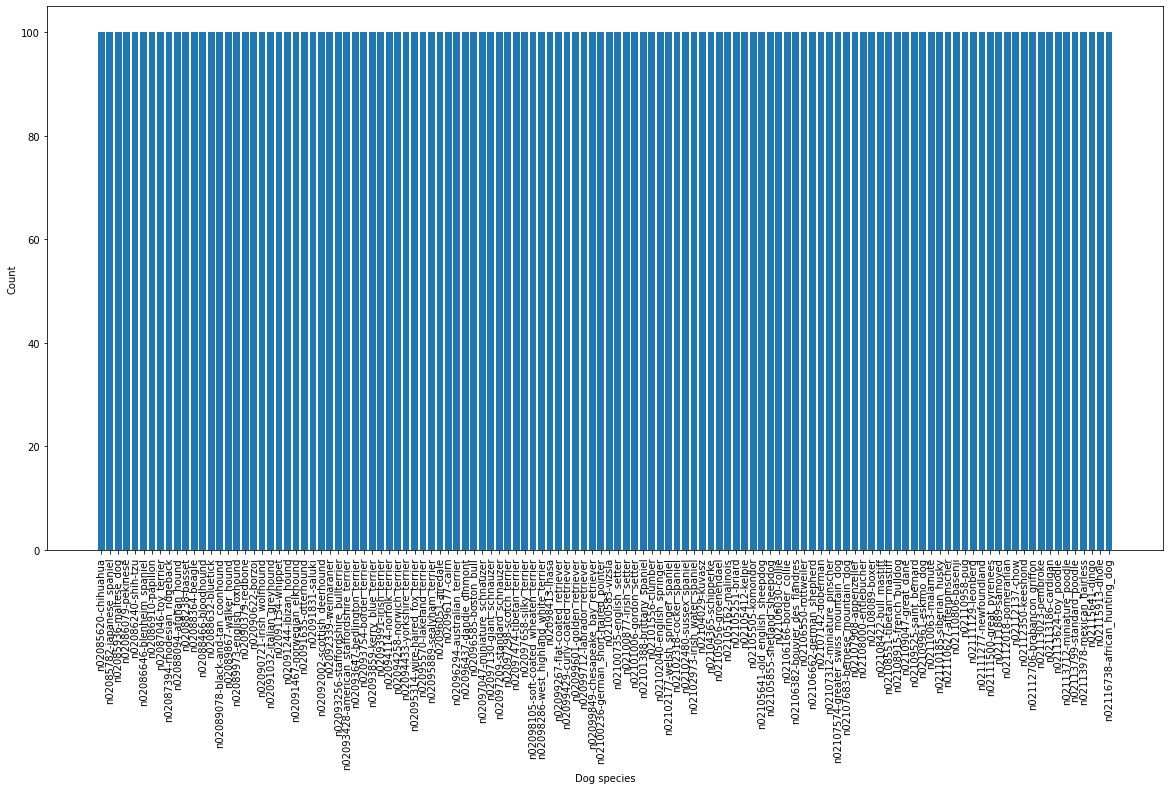

In [14]:
plt.figure(figsize=(20, 10))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Dog species')
plt.ylabel('Count')
plt.show()

In [15]:
class_counts # class별 100개씩 120개의 종이 분포(균일)

{'n02085620-chihuahua': 100,
 'n02085782-japanese_spaniel': 100,
 'n02085936-maltese_dog': 100,
 'n02086079-pekinese': 100,
 'n02086240-shih-tzu': 100,
 'n02086646-blenheim_spaniel': 100,
 'n02086910-papillon': 100,
 'n02087046-toy_terrier': 100,
 'n02087394-rhodesian_ridgeback': 100,
 'n02088094-afghan_hound': 100,
 'n02088238-basset': 100,
 'n02088364-beagle': 100,
 'n02088466-bloodhound': 100,
 'n02088632-bluetick': 100,
 'n02089078-black-and-tan_coonhound': 100,
 'n02089867-walker_hound': 100,
 'n02089973-english_foxhound': 100,
 'n02090379-redbone': 100,
 'n02090622-borzoi': 100,
 'n02090721-irish_wolfhound': 100,
 'n02091032-italian_greyhound': 100,
 'n02091134-whippet': 100,
 'n02091244-ibizan_hound': 100,
 'n02091467-norwegian_elkhound': 100,
 'n02091635-otterhound': 100,
 'n02091831-saluki': 100,
 'n02092002-scottish_deerhound': 100,
 'n02092339-weimaraner': 100,
 'n02093256-staffordshire_bullterrier': 100,
 'n02093428-american_staffordshire_terrier': 100,
 'n02093647-bedlingt

## 1. Augmentation을 적용한 데이터셋 만들기
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

Q. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?
> CutMix를 batch() 함수 뒤에 위치시키는 주요 이유는 다음과 같습니다:

> 데이터 효율성: batch() 함수는 여러 개의 개별 데이터 샘플을 하나의 배치로 그룹화합니다. CutMix를 이 배치 단위로 적용하면, 한 번의 연산으로 여러 샘플에 대해 CutMix를 수행할 수 있어 계산 효율성이 높아집니다.

> 메모리 사용 최적화: 배치 처리 후 CutMix를 적용하면 메모리 사용을 최적화할 수 있습니다. 개별 샘플에 CutMix를 적용한 후 배치를 만드는 것보다 메모리 효율적입니다.

> 일관된 배치 크기: batch() 함수 이후에 CutMix를 적용하면 모든 배치가 일정한 크기를 유지합니다. 이는 모델 학습 시 안정성을 높이고 예측 가능한 메모리 사용을 가능하게 합니다.

> 데이터 증강의 다양성: 배치 내에서 CutMix를 적용하면 같은 배치 내의 다른 이미지들과 혼합될 수 있어, 데이터 증강의 다양성이 증가합니다.

> GPU 활용 최적화: 배치 단위로 처리하면 GPU의 병렬 처리 능력을 최대한 활용할 수 있어, CutMix 연산의 속도가 향상됩니다.

> 학습 과정의 안정성: 배치 정규화 등의 기법이 CutMix 이전에 적용되어, 학습 과정이 더 안정적으로 진행될 수 있습니다.

> 이러한 이유들로 인해 CutMix를 batch() 함수 이후에 적용하는 것이 일반적으로 더 효과적이고 효율적인 방법으로 여겨집니다.


In [16]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

# x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

# print('x : ', x_min, x_max)
# print('y : ', y_min, y_max)

In [17]:
# mix two labels
def mix_2_labels(image_a, 
                 label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

# mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
# mixed_label

In [18]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [19]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, 
                                         label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [20]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


In [21]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [22]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label


In [23]:
# Considering all cases
def apply_normalize_on_dataset(ds, is_test=False, 
                               batch_size=16,
                               with_aug=False,
                               with_cutmix=False, 
                               with_mixup=False
                               ):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,
            num_parallel_calls=2
        )

    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    
    else :  # cutmix, mixup과 모양을 맞춰주기
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
            
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


## 2. 모델 만들기
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.
> 함수화를 진행하여, 함수 내에 모델을 생성

In [24]:
# dataset 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

# For test 
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## 3. 모델 훈련하기
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

Q. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?
> 우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

### 기본 Augmentation model

In [106]:
next(iter(ds_train_no_aug))
# Batch data : <tf.Tensor: shape=(16, 224, 224, 3), dtype=float32>, 
# Batch label : <tf.Tensor: shape=(16, 120), dtype=float32>, 

(<tf.Tensor: shape=(16, 224, 224, 3), dtype=float32, numpy=
 array([[[[7.20185518e-01, 8.30794811e-01, 5.26418030e-01],
          [7.07417011e-01, 8.21142495e-01, 5.05712867e-01],
          [6.89948916e-01, 8.03569436e-01, 4.74157631e-01],
          ...,
          [6.53331935e-01, 7.83163965e-01, 6.13695920e-01],
          [8.36412370e-01, 9.37183082e-01, 8.04724336e-01],
          [9.41771865e-01, 1.00000000e+00, 9.22164023e-01]],
 
         [[7.43318081e-01, 8.57043564e-01, 5.41252315e-01],
          [7.21568525e-01, 8.35294008e-01, 5.13550580e-01],
          [6.93463802e-01, 8.07084262e-01, 4.77666408e-01],
          ...,
          [6.54085755e-01, 7.83917844e-01, 6.14449799e-01],
          [8.36412370e-01, 9.37183082e-01, 8.04724336e-01],
          [9.41771865e-01, 1.00000000e+00, 9.22164023e-01]],
 
         [[7.50647724e-01, 8.64988029e-01, 5.35821378e-01],
          [7.21842647e-01, 8.36717486e-01, 5.06150305e-01],
          [6.80689812e-01, 7.97223747e-01, 4.61879939e-01],
    

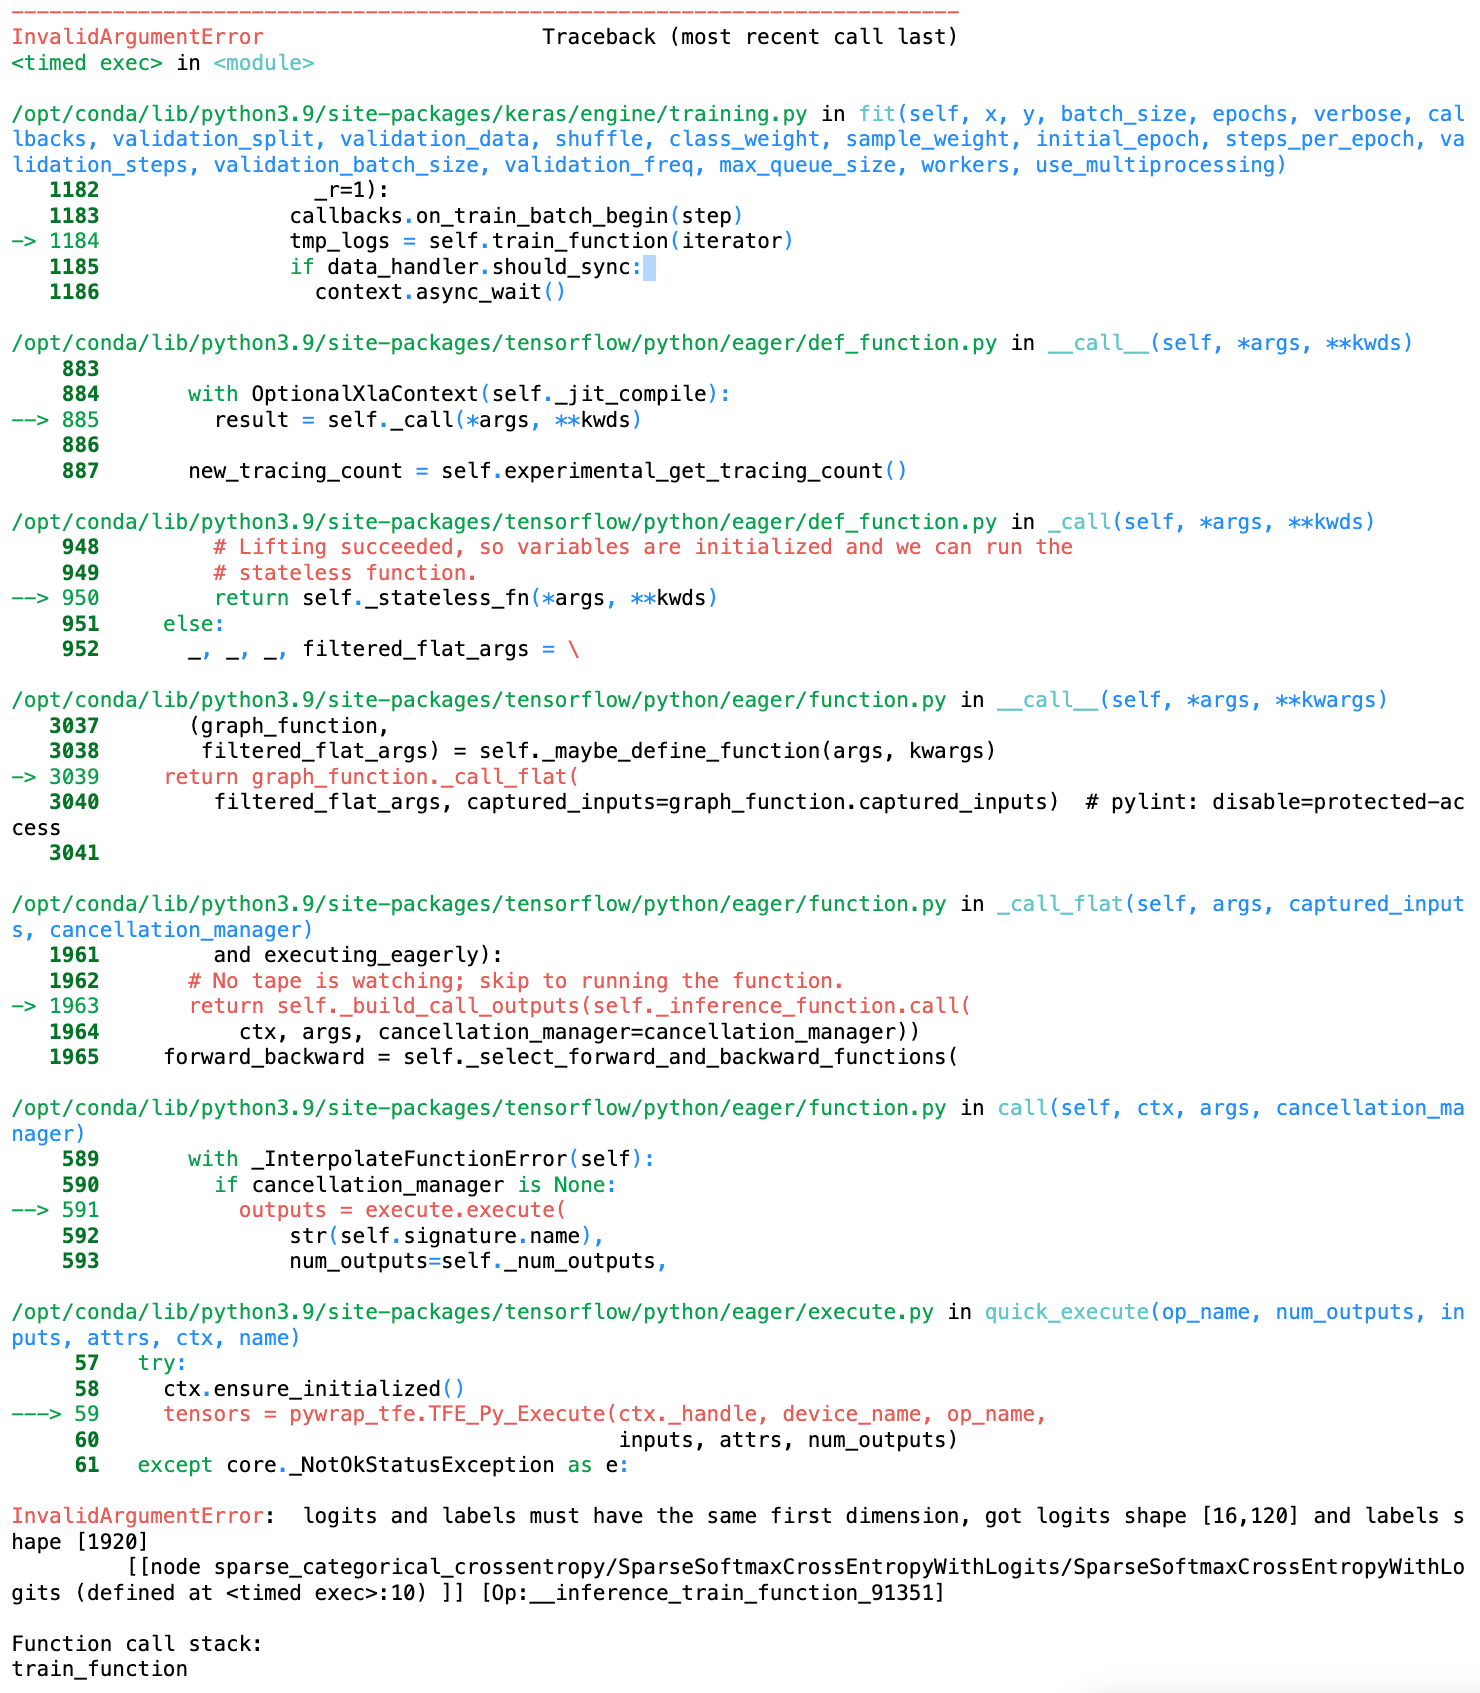
> Shape에 대한 에러가 발생했다. 왜 그런가 확인해보니, onehot을 cutmix, mixup이 아닌 부분에 대해 적용해야되는데 반대로 생각했고, 
해당 비교실험을 위해서 onehot이 되어있기 때문에 sparse_categorical_crossentropy대신 categorical_crossentropy 적용이 필요함.

In [108]:
%%time
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 1

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

750/750 [==============================] - 162s 202ms/step - loss: 2.1830 - accuracy: 0.4516 - val_loss: 3.5084 - val_accuracy: 0.1859
CPU times: user 2min 57s, sys: 4.78 s, total: 3min 2s
Wall time: 2min 42s


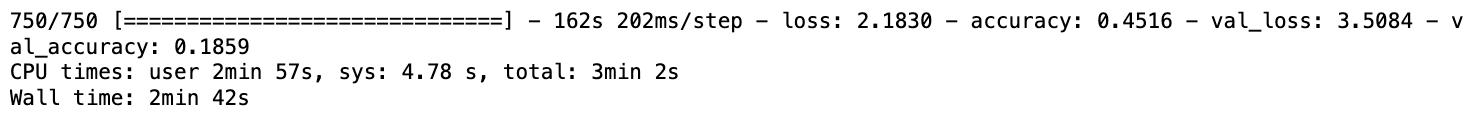

- 1Epoch을 학습하는데에 약 3분이 소요된다. 20Epoch를 돌리기위해서는 1시간이 필요할 것 같다.

In [25]:
# 학습 함수를 모듈화
def train_model(ds_train, 
               epochs=1):
    model = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

    history = model.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=epochs,
        validation_data=ds_test, # global로 사용합니다.
        verbose=1,
        use_multiprocessing=True,
    )
    return model, history

In [114]:
# 함수화 test
model_no_aug = train_model(ds_train=ds_train_no_aug)

750/750 [==============================] - 160s 204ms/step - loss: 2.1942 - accuracy: 0.4466 - val_loss: 3.3889 - val_accuracy: 0.2201


In [26]:
from collections import defaultdict

# Train all cases
all_train_datasets = {
    "No_Augmentation" : ds_train_no_aug, 
    "Augmentation" : ds_train_aug, 
    "Cutmix" : ds_train_cutmix, 
    "Mixup" : ds_train_mixup
}

# save for history
histories = defaultdict(dict)
models = defaultdict(dict)

In [122]:
%%time
# check elapsed times with all models for 1 epochs
for ds_name, ds_train in all_train_datasets.items() : 
    
    model, history = train_model(ds_train=ds_train)
    
    # save data
    models[ds_name] = model
    histories[ds_name] = history

750/750 [==============================] - 180s 215ms/step - loss: 3.7796 - accuracy: 0.2225 - val_loss: 4.8190 - val_accuracy: 0.0708
CPU times: user 14min 25s, sys: 28.2 s, total: 14min 54s
Wall time: 12min 11s


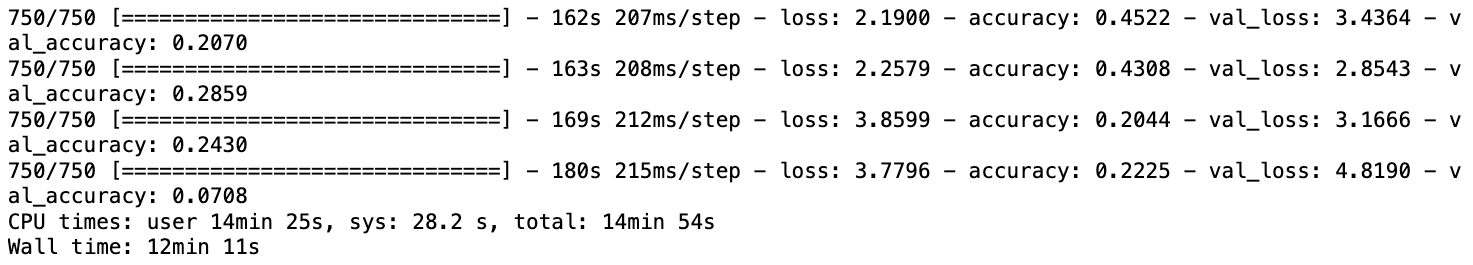
- 4개 모델에 대해서 1Epoch를 진행했을때, 약 12분이 소요되었고, val_accuracy의 정확도 기준으로 보면 augmentation이 가장 높게 분포하는 것을 확인
- mixup의 경우에는 상당히 낮게(7%) 분포하는 것이 특이하다. 

#### 개별 객체들에 대한 저장 여부 확인

In [132]:
# histories['Mixup'].history

{'loss': [3.779557943344116],
 'accuracy': [0.2224999964237213],
 'val_loss': [4.819046497344971],
 'val_accuracy': [0.07077892124652863]}

In [126]:
# models

defaultdict(dict,
            {'No_Augmentation': <keras.engine.sequential.Sequential at 0x7cd8fdf962b0>,
             'Augmentation': <keras.engine.sequential.Sequential at 0x7cd8f488be20>,
             'Cutmix': <keras.engine.sequential.Sequential at 0x7cd8fd69e700>,
             'Mixup': <keras.engine.sequential.Sequential at 0x7cd8d9fe9280>})

In [133]:
# models['Mixup'].save_weights('./mixup.h5')

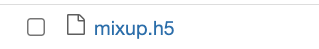

In [137]:
import pandas as pd

# 모델 및 훈련 결과 Log 저장
def save_history_and_model_weights(model_name):
    
    model = models[model_name]
    history = histories[model_name].history
    epoch=len(history['loss'])
    
    model.save_weights(f'./models/Resnet50_{model_name}_{epoch}epoch.h5')
    df_history = pd.DataFrame(history)
    df_history.to_csv(f'./history/Resnet50_{model_name}_{epoch}epoch.csv')
    
save_history_and_model_weights('Mixup')

In [ ]:
model_names = all_train_datasets.keys()

# 각 모델들과 학습 결과를 저장합니다. 
for model_name in model_names : 
    save_history_and_model_weights(model_name)

### 모든 경우에 대한 학습 총 진행

In [ ]:
%%time
# 20에폭을 각 모델에 대해 진행 - 12*20 = 240분, 4시간이 소요될 것으로 예상
EPOCH = 20

for ds_name, ds_train in all_train_datasets.items() : 
    
    model, history = train_model(ds_train=ds_train, epochs=EPOCH)
    
    # save data
    models[ds_name] = model
    histories[ds_name] = history
    
    model.save_weights(f'./models/Resnet50_{ds_name}_{EPOCH}epoch.h5')
    df_history = pd.DataFrame(history.history)
    df_history.to_csv(f'./history/Resnet50_{ds_name}_{EPOCH}epoch.csv')


Epoch 1/20
750/750 [==============================] - 165s 212ms/step - loss: 2.1938 - accuracy: 0.4495 - val_loss: 3.4242 - val_accuracy: 0.2066
Epoch 2/20
750/750 [==============================] - 158s 211ms/step - loss: 0.6989 - accuracy: 0.8100 - val_loss: 1.0782 - val_accuracy: 0.6858
Epoch 3/20
750/750 [==============================] - 156s 208ms/step - loss: 0.2179 - accuracy: 0.9565 - val_loss: 0.9320 - val_accuracy: 0.7252
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0602 - accuracy: 0.9952 - val_loss: 0.9086 - val_accuracy: 0.7408
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0275 - accuracy: 0.9990 - val_loss: 0.9328 - val_accuracy: 0.7380
Epoch 6/20
750/750 [==============================] - 158s 210ms/step - loss: 0.0176 - accuracy: 0.9996 - val_loss: 0.9359 - val_accuracy: 0.7364
Epoch 7/20
750/750 [==============================] - 170s 227ms/step - loss: 0.0140 - accuracy: 0.9994 - val_loss: 0.9545 -

In [28]:
import pandas as pd

In [29]:
%%time
# 20에폭을 각 모델에 대해 진행 - 12*20 = 240분, 4시간이 소요될 것으로 예상
EPOCH = 20

for ds_name, ds_train in all_train_datasets.items() : 
    if ds_name in ["No_Augmentation", "Augmentation"] :
        continue
    model, history = train_model(ds_train=ds_train, epochs=EPOCH)
    
    # save data
    models[ds_name] = model
    histories[ds_name] = history
    
    model.save_weights(f'./models/Resnet50_{ds_name}_{EPOCH}epoch.h5')
    df_history = pd.DataFrame(history.history)
    df_history.to_csv(f'./history/Resnet50_{ds_name}_{EPOCH}epoch.csv')


Epoch 1/20
750/750 [==============================] - 162s 206ms/step - loss: 3.8454 - accuracy: 0.2036 - val_loss: 2.8574 - val_accuracy: 0.2849
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 2.7492 - accuracy: 0.4980 - val_loss: 1.2701 - val_accuracy: 0.6379
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 2.5678 - accuracy: 0.5477 - val_loss: 1.2193 - val_accuracy: 0.6510
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 2.4373 - accuracy: 0.5843 - val_loss: 1.1817 - val_accuracy: 0.6742
Epoch 6/20
750/750 [==============================] - 153s 205ms/step - loss: 2.3143 - accuracy: 0.6274 - val_loss: 1.1337 - val_accuracy: 0.6849
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 2.2429 - accuracy: 0.6578 - val_loss: 1.2191 - val_accuracy: 0.6658
Epoch 8/20
750/750 [==============================] - 153s 204ms/step - loss: 2.1764 - accuracy: 0.6800 - val_loss: 1.2210 -

## 4. 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

In [35]:
model_names = all_train_datasets.keys()
model_names

dict_keys(['No_Augmentation', 'Augmentation', 'Cutmix', 'Mixup'])

In [51]:
histories['Mixup'].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [72]:
import pandas as pd

# 시각화에 대한 모듈화
def plot_history(model_name):
    history = pd.read_csv(f'./history/Resnet50_{model_name}_{EPOCH}epoch.csv')

    x = range(1, len(history['val_accuracy'])+1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    
    plt.plot(x, history['loss'], 'r', label='train_loss')
    plt.plot(x, history['val_loss'], 'b', label='valid_loss')

    plt.title(f'{model_name} Model Loss Result')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.xticks(x)

    plt.legend(loc='upper right')
    
    
    if 'val_accuracy' in history : 
        # Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(x, history['accuracy'], 'r', label='train_accuracy')
        plt.plot(x, history['val_accuracy'], 'b', label='valid_accuracy')
        
        plt.title(f'{model_name} Model Accuracy Result')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.xticks(x)
        plt.ylim(0.50, 1.02)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
        print("Maximum Valid Accurary : {:.4f}".format(max(history['val_accuracy'])))
        
    plt.tight_layout()
    plt.savefig(f'./history/Resnet50_{model_name}_{EPOCH}_figure_result.png')
    plt.show()
    


## 5. Augmentation에 의한 모델 성능 비교
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상
- 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

Maximum Valid Accurary : 0.7408


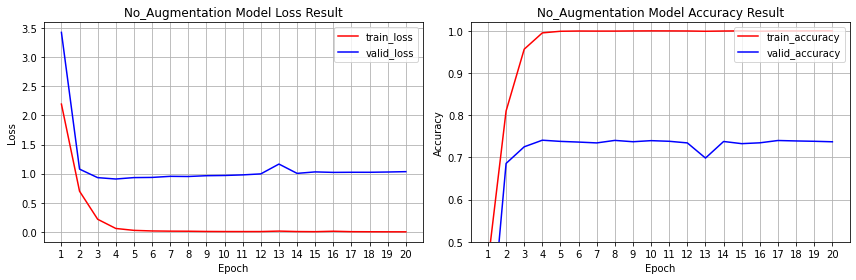

Maximum Valid Accurary : 0.7533


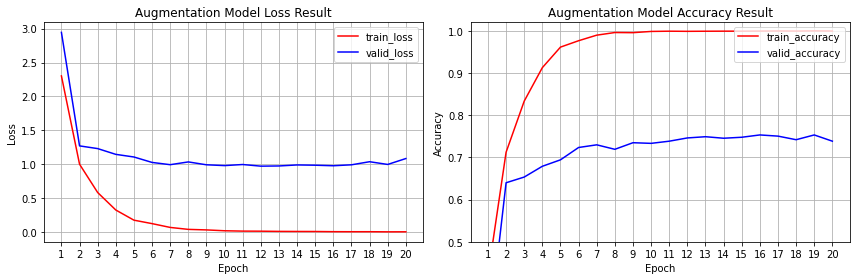

Maximum Valid Accurary : 0.7056


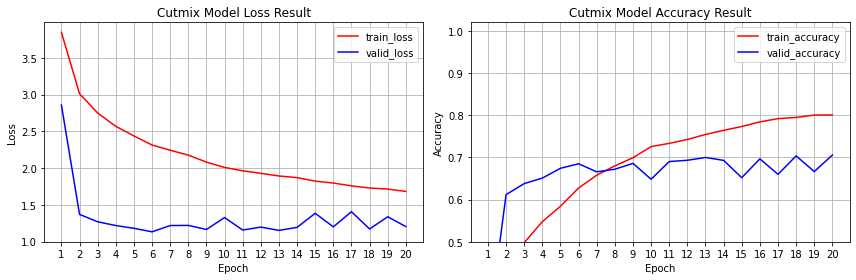

Maximum Valid Accurary : 0.6955


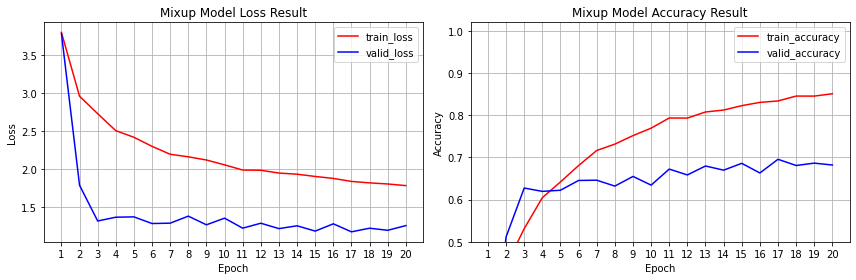

In [73]:
for model_name in model_names : 
    plot_history(model_name)

#### 20Epoch 훈련 이후 결과 분석
- Loss값의 경우 4개의 모델 모두 정상적으로 학습이 진행된 듯 한 경향을 확인
    - No_Augmentation과 Augmentation의 경우에는 2-3 에폭 이후 오버피팅이 되는 것을 확인
    - 반면, Cutmix와 Mixup의 경우에는 오히려 valid loss 값이 더 작게 산출
- 하지만, Accuracy의 경우 
    - Augmentation을 적용 시 1.2% 소폭 상승한 결과를 확인하였고, 
    - Mixup, Cutmix를 적용하였을 때 약 5%정도 떨어지는 것을 확인하였다. 

In [111]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

class_counts = {name: 0 for name in class_names}

for _, label in ds_test:
    class_counts[class_names[label.numpy()]] += 1

In [112]:
class_counts

{'n02085620-chihuahua': 52,
 'n02085782-japanese_spaniel': 85,
 'n02085936-maltese_dog': 152,
 'n02086079-pekinese': 49,
 'n02086240-shih-tzu': 114,
 'n02086646-blenheim_spaniel': 88,
 'n02086910-papillon': 96,
 'n02087046-toy_terrier': 72,
 'n02087394-rhodesian_ridgeback': 72,
 'n02088094-afghan_hound': 139,
 'n02088238-basset': 75,
 'n02088364-beagle': 95,
 'n02088466-bloodhound': 87,
 'n02088632-bluetick': 71,
 'n02089078-black-and-tan_coonhound': 59,
 'n02089867-walker_hound': 53,
 'n02089973-english_foxhound': 57,
 'n02090379-redbone': 48,
 'n02090622-borzoi': 51,
 'n02090721-irish_wolfhound': 118,
 'n02091032-italian_greyhound': 82,
 'n02091134-whippet': 87,
 'n02091244-ibizan_hound': 88,
 'n02091467-norwegian_elkhound': 96,
 'n02091635-otterhound': 51,
 'n02091831-saluki': 100,
 'n02092002-scottish_deerhound': 132,
 'n02092339-weimaraner': 60,
 'n02093256-staffordshire_bullterrier': 55,
 'n02093428-american_staffordshire_terrier': 64,
 'n02093647-bedlington_terrier': 82,
 'n0209

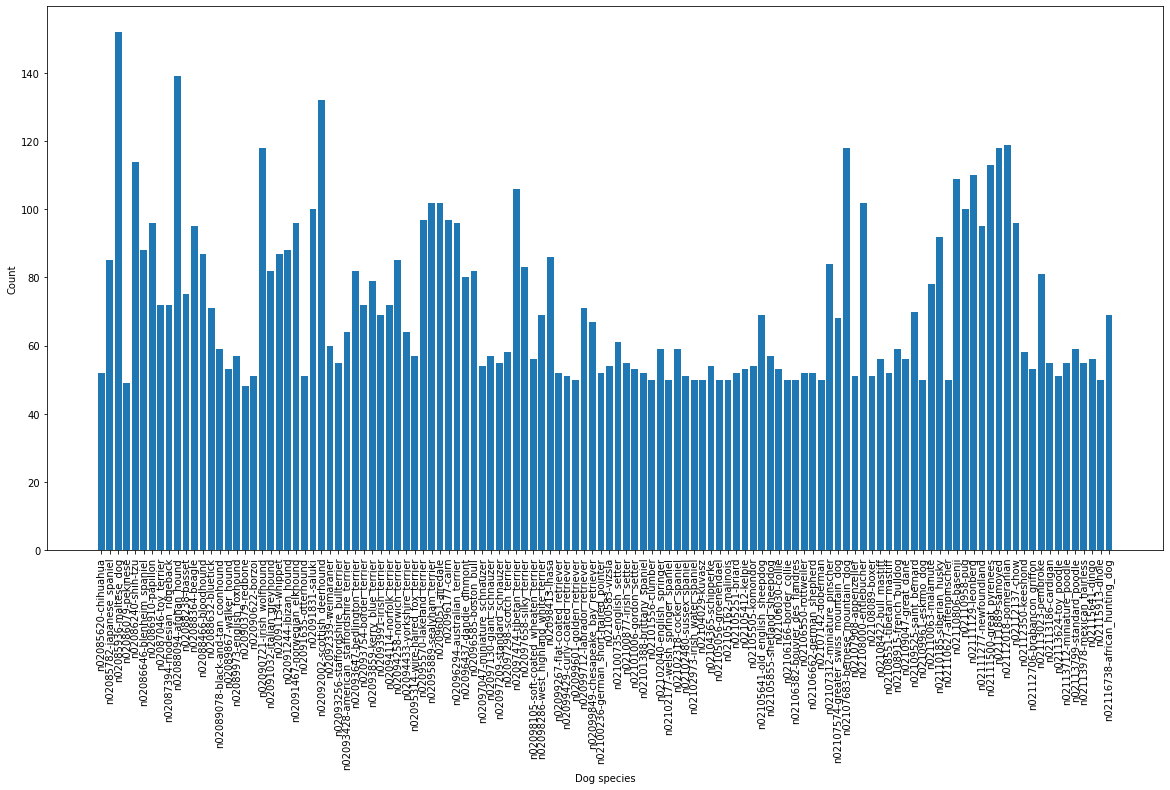

In [113]:
# Test data에 대한 시각화
plt.figure(figsize=(20, 10))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Dog species')
plt.ylabel('Count')
plt.show()

## Heatmap을 확인

In [114]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

ds_name = 'No_Augmentation'

MODEL_PATH = f'./models/Resnet50_{ds_name}_{EPOCH}epoch.h5'
MODEL_PATH

'./models/Resnet50_No_Augmentation_20epoch.h5'

In [115]:
test_model = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
    ])
test_model.load_weights(MODEL_PATH)

In [118]:
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [119]:
# 모델 예측
y_pred = test_model.predict(ds_test)
y_pred_classes = np.argmax(y_pred, axis=1)

In [120]:
y_pred_classes

array([75, 71, 11, ..., 85,  6, 26])

In [121]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [122]:
len(y_test)

8580

In [123]:
y_test_labels = np.argmax(y_test, axis=1)  # 원핫 인코딩을 라벨로 변환

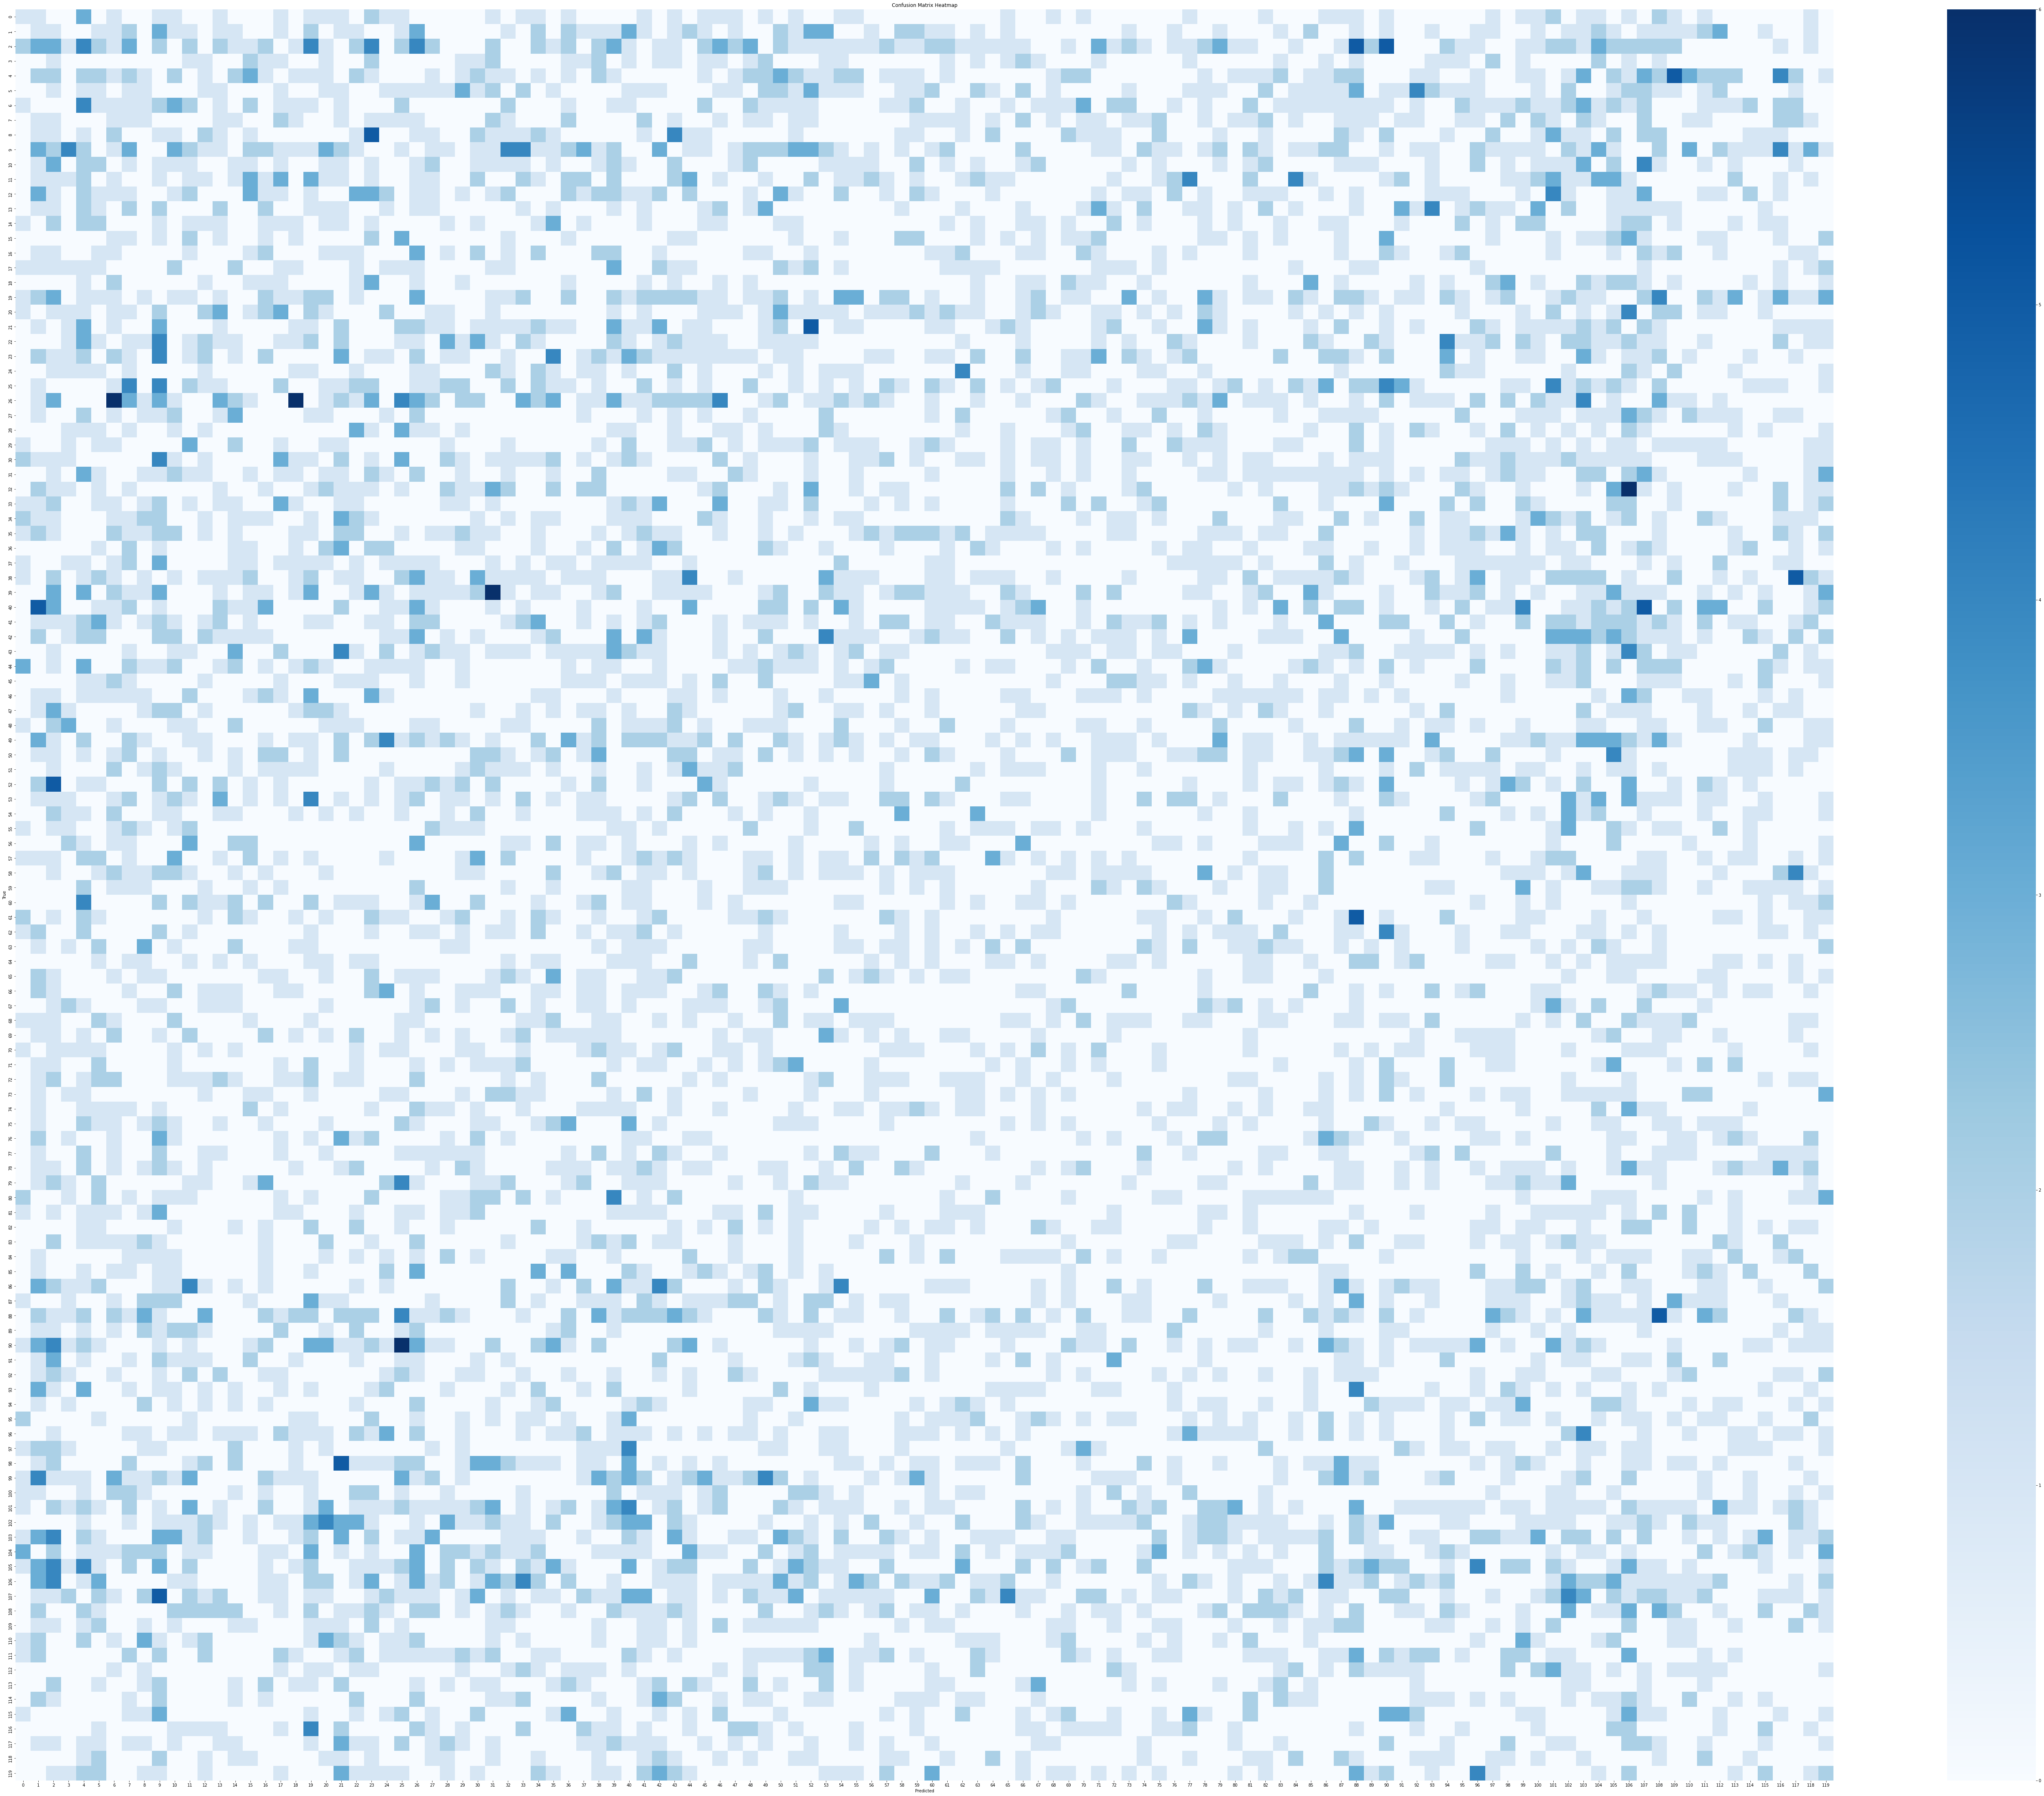

In [124]:
# Confusion Matrix 계산
conf_matrix = confusion_matrix(y_test_labels, y_pred_classes)

# Confusion Matrix를 Heatmap으로 시각화
plt.figure(figsize=(100, 80))
sns.heatmap(conf_matrix, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

- 종이 너무 많아서(120개...) Heatmap으로의 분석이 좀 힘들다.

# 회고

- Mixup, Cutmix가 Overfitting에 강건하다고 학습을 하였는데, 꼭 그렇지만은 않은 것 같다.
- 학습 진행 시 결과물(모델 가중치, Loss 경향 등)을 꼭 저장하는 습관을 가져야겠다.
- 매번 필요하면 그때그때 작성하면서 요구되는 것들을 채워나갔었는데, 앞으로는 해당 노드에서 학습했던 것을 기본 템플릿으로 가져가서, 향후의 노드 학습시에는 그대로 가져다써서 시간과 머리를 덜 쓰는 쪽으로 해야겠음.

### 실험의 정확도, 효율을 위해 추가적으로 더 적용해 볼 기법들
- control random seed
- early-stopping for useless training
- wandb monitoring at realtime
- 정성적인 결과 비교
- csv-logger
- save_best_weight